In [1]:
#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# #loading data

# download.file("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn", "tennis_data.csv")
 tennis_data <- read_csv("tennis_data.csv", show_col_types = FALSE)
# #tennis_data

New names:
• `` -> `...1`


In [3]:
#prepping data
set.seed(2132)

winner_data <- tennis_data |> select(winner_rank_points, winner_ht, w_df, w_bpSaved, w_bpFaced) |> 
    filter(w_bpSaved != 0) |> filter(w_bpFaced != 0) |> mutate(bpratio = w_bpSaved/w_bpFaced) |> na.omit() |>
    rename(rank_points = winner_rank_points, height = winner_ht, double_faults = w_df) |>
    select(-w_bpSaved, -w_bpFaced)
loser_data <- tennis_data |> select(loser_rank_points, loser_ht, l_df, l_bpSaved, l_bpFaced) |> 
    filter(l_bpSaved != 0) |> filter(l_bpFaced != 0) |> mutate(bpratio = l_bpSaved/l_bpFaced) |> na.omit() |>
    rename(rank_points = loser_rank_points, height = loser_ht, double_faults = l_df) |>
    select(-l_bpSaved, -l_bpFaced)

player_data <- rbind(winner_data, loser_data)

player_split <- initial_split(player_data, prop = .75, strata = rank_points)  
player_train <- training(player_split)
player_test <- testing(player_split)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
111,rmse,standard,1697.243,5,56.82302,Preprocessor1_Model12


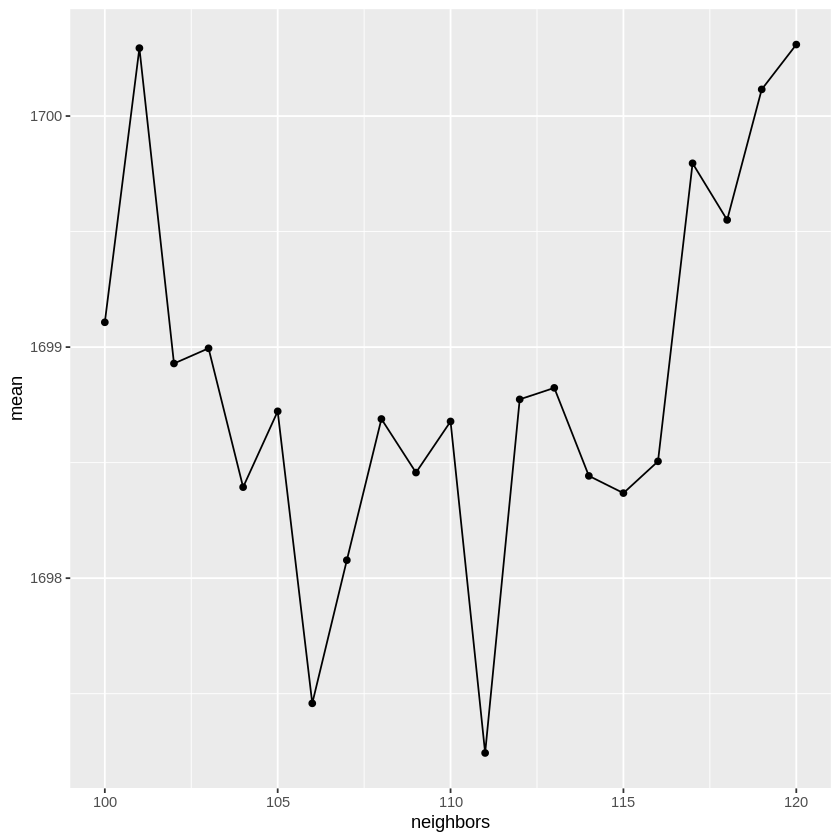

In [17]:
# testing/tuning regression

# height and df: best k = 143 - rmse = 1722.395
# height, df, bp: best k = 27 - rmse = 1732.282
# df and bp: best k = 322 - rmse = 1808.461
# height and bp: best k = 111 - rmse = 1697.243

set.seed(5342)

recipe <- recipe(rank_points ~ bpratio + height, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

workflow <- workflow() |>
    add_recipe(recipe) |>
    add_model(spec)

vfold <- vfold_cv(player_train, v = 5, strata = rank_points)
gridvals <- tibble(neighbors = seq(from = 100, to = 120, by = 1))

results <- workflow |>
    tune_grid(resamples = vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min <- results |>
    filter(mean == min(mean))
min

k_win_selec <- ggplot(results, aes(x = neighbors, y = mean)) + geom_point() + geom_line()
k_win_selec